# TensorFlow examples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version: {0}".format(tf.__version__))

TensorFlow version: 1.15.0


## Simple calculation

### $ z = 2 \times (a - b) + c $

In [3]:
g = tf.Graph()

with g.as_default():
    a = tf.constant(1, name='a')
    b = tf.constant(2, name='b')
    c = tf.constant(3, name='c')
    
    z = 2 * (a - b) + c

with tf.Session(graph=g) as sess:
    print('2*(a-b) + c => ', sess.run(z))

2*(a-b) + c =>  1


### Using placeholders

In [9]:
g = tf.Graph()
with g.as_default():
    tf_a = tf.placeholder(tf.int32, shape=[],
                          name='tf_a')
    tf_b = tf.placeholder(tf.int32, shape=[],
                          name='tf_b')
    tf_c = tf.placeholder(tf.int32, shape=[],
                          name='tf_c')
    
    r1 = tf_a - tf_b
    r2 = 2 * r1
    z = r2 + tf_c

with tf.Session(graph=g) as sess:
    # TensorFlow requires tensor name to be in "op_name:output_index" format
    feed = {'tf_a:0': 1, 'tf_b:0': 2, 'tf_c:0': 3}
    print('2*(a-b) + c => ', sess.run(z, feed_dict=feed))

2*(a-b) + c =>  1


### $ z = w \times x + b $ 

In [2]:
# create a graph
g1 = tf.Graph()
with g1.as_default():
    x = tf.placeholder(dtype=tf.float32,
                       shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    
    z = w * x + b
    
    init = tf.global_variables_initializer()

# create a session and pass in a graph g
with tf.Session(graph=g1) as sess:
    # initialize w and b:
    sess.run(init)
    # evaluate z:
    for t in [1.0, 0.6, -1.8]:
        print('x={0:.1f} --> z={1:.1f}'.format(t, sess.run(z, feed_dict={x:t})))

x=1.0 --> z=2.7
x=0.6 --> z=1.9
x=-1.8 --> z=-2.9


## Get rank and shape of a tensor

In [2]:
g = tf.Graph()

## define the computation graph
with g.as_default():
    ## define tensors t1, t2, t3
    t1 = tf.constant(np.pi)
    t2 = tf.constant([1, 2, 3, 4])
    t3 = tf.constant([[1, 2], [3, 4]])

    ## get their ranks
    r1 = tf.rank(t1)
    r2 = tf.rank(t2)
    r3 = tf.rank(t3)

    ## get their shapes
    s1 = t1.get_shape()
    s2 = t2.get_shape()
    s3 = t3.get_shape()
    print('Shapes:', s1, s2, s3)

with tf.Session(graph=g) as sess:
    print('Ranks:',
          r1.eval(),
          r2.eval(),
          r3.eval())

Shapes: () (4,) (2, 2)
Ranks: 0 1 2


## Placeholders for data arrays with varying batch sizes

In [14]:
g = tf.Graph()

with g.as_default():
    tf_x = tf.placeholder(tf.float32,
                          shape=[None, 2],
                          name='tf_x')
    print(tf_x)

Tensor("tf_x:0", shape=(?, 2), dtype=float32)


In [15]:
g = tf.Graph()

with g.as_default():
    tf_x = tf.placeholder(tf.float32,
                          shape=[None, 2],
                          name='tf_x')
    x_mean = tf.reduce_mean(tf_x,
                            axis=0,
                            name='mean')

np.random.seed(123)
np.set_printoptions(precision=2)
with tf.Session(graph=g) as sess:
    x1 = np.random.uniform(low=0, high=1, size=(5, 2))
    print('Feeding data with shape ', x1.shape)
    print('Result:', sess.run(x_mean, feed_dict={tf_x: x1}))

    x2 = np.random.uniform(low=0, high=1, size=(10,2))
    print('Feeding data with shape', x2.shape)
    print('Result:', sess.run(x_mean, feed_dict={tf_x: x2}))

Feeding data with shape  (5, 2)
Result: [0.62 0.47]
Feeding data with shape (10, 2)
Result: [0.46 0.49]


## Using variables

In [19]:
g = tf.Graph()

with g.as_default():
    w = tf.Variable(np.array([[1, 2, 3, 4],
                              [5, 6, 7, 8]]), name='w')
    print(w)

<tf.Variable 'w:0' shape=(2, 4) dtype=int64_ref>


Tensors defined as variables are not allocated in memory and contain no values until they are initialized. Therefore, before executing any node in the computation graph, we **must** initialize the variables that are within the path to the node that we want to execute. This initialization process refers to allocating memory for the associated tensors and assigning their initial values.

In [22]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(w))

[[1 2 3 4]
 [5 6 7 8]]


## Variable scope

In [23]:
g = tf.Graph()

with g.as_default():
    with tf.variable_scope('net_A'):
        with tf.variable_scope('layer-1'):
            w1 = tf.Variable(tf.random_normal(shape=(10,4)), name='weights')
        with tf.variable_scope('layer-2'):
            w2 = tf.Variable(tf.random_normal(shape=(20,10)), name='weights')
    with tf.variable_scope('net_B'):
        with tf.variable_scope('layer-1'):
            w3 = tf.Variable(tf.random_normal(shape=(10,4)), name='weights')
    
    print(w1)
    print(w2)
    print(w3)

<tf.Variable 'net_A/layer-1/weights:0' shape=(10, 4) dtype=float32_ref>
<tf.Variable 'net_A/layer-2/weights:0' shape=(20, 10) dtype=float32_ref>
<tf.Variable 'net_B/layer-1/weights:0' shape=(10, 4) dtype=float32_ref>


## Reusing variables

In [25]:
###########################
##   Helper functions    ##
###########################
 
def build_classifier(data, labels, n_classes=2):
    data_shape = data.get_shape().as_list()
    weights = tf.get_variable(name='weights',
                              shape=(data_shape[1],
                                     n_classes),
                              dtype=tf.float32)
    bias = tf.get_variable(name='bias',
                           initializer=tf.zeros(shape=n_classes))
    logits = tf.add(tf.matmul(data, weights),
                    bias,
                    name='logits')
    return logits, tf.nn.softmax(logits)


def build_generator(data, n_hidden):
    data_shape = data.get_shape().as_list()
    w1 = tf.Variable(tf.random_normal(shape=(data_shape[1], 
                                             n_hidden)),
                     name='w1')
    b1 = tf.Variable(tf.zeros(shape=n_hidden),
                     name='b1')
    hidden = tf.add(tf.matmul(data, w1), b1,
                    name='hidden_pre-activation')
    hidden = tf.nn.relu(hidden, 'hidden_activation')
    
    w2 = tf.Variable(tf.random_normal(shape=(n_hidden,
                                             data_shape[1])),
                     name='w2')
    b2 = tf.Variable(tf.zeros(shape=data_shape[1]),
                     name='b2')
    output = tf.add(tf.matmul(hidden, w2), b2,
                    name = 'output')
    return output, tf.nn.sigmoid(output)

###########################
##  Build the graph      ##
###########################

batch_size=64
g = tf.Graph()

with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100),
                          dtype=tf.float32,
                          name='tf_X')

    ## build the generator
    with tf.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X,
                                   n_hidden=50)

    ## build the classifier
    with tf.variable_scope('classifier') as scope:
        ## classifier for the original data:
        cls_out1 = build_classifier(data=tf_X,
                                    labels=tf.ones(shape=batch_size))

        ## reuse the classifier for generated data
        scope.reuse_variables()
        cls_out2 = build_classifier(data=gen_out1[1],
                                    labels=tf.zeros(shape=batch_size))

### Alternative implementation

In [26]:
g = tf.Graph()

with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100),
                          dtype=tf.float32,
                          name='tf_X')
    ## build the generator
    with tf.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X,
                                   n_hidden=50)

    ## build the classifier
    with tf.variable_scope('classifier'):
        ## classifier for the original data:
        cls_out1 = build_classifier(data=tf_X,
                                    labels=tf.ones(shape=batch_size))
         
    with tf.variable_scope('classifier', reuse=True):
        ## reuse the classifier for generated data
        cls_out2 = build_classifier(data=gen_out1[1],
                                    labels=tf.zeros(shape=batch_size))

## Reshape rank-3 tensor, compute column sums and means

In [5]:
g2 = tf.Graph()
with g2.as_default():
    # input tensor
    x = tf.placeholder(dtype=tf.float32,
                       shape=(None, 2, 3),
                       name='input_x')
    # reshape input
    x2 = tf.reshape(x, shape=(-1, 6), name='x2')
    # calculate the sum of each column
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')
    # calculate the mean of each column
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')

with tf.Session(graph=g2) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    print("Input tensor:\n{0}\nInput shape:\n{1}".format(x_array, x_array.shape))
    x_resh = sess.run(x2, feed_dict={x:x_array})
    print("Reshaped:\n{0}\nReshaped shape\n{1}:".format(x_resh, x_resh.shape))
    print("Column sums:\n{0}".format(sess.run(xsum, feed_dict={x:x_array})))
    print("Column means:\n{0}".format(sess.run(xmean, feed_dict={x:x_array})))

Input tensor:
[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]]]
Input shape:
(3, 2, 3)
Reshaped:
[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Reshaped shape
(3, 6):
Column sums:
[18. 21. 24. 27. 30. 33.]
Column means:
[ 6.  7.  8.  9. 10. 11.]


## Ordinary Least Squares (OLS) regression
Implementing a simple Ordinary Least Squares (OLD) OLS regression model:

$ z = w \times x + b $

using the Mean of Squared Error (MSE) cost function:

$ MSE = \frac{1} {n} \sum \limits_{i=1}^n \left( y_i - \hat{y}_i \right) ^2 $

In [27]:
g = tf.Graph()

with g.as_default():
    tf.set_random_seed(123)
    # placeholders
    tf_x = tf.placeholder(shape=(None),
                          dtype=tf.float32,
                          name='tf_x')
    tf_y = tf.placeholder(shape=(None),
                          dtype=tf.float32,
                          name='tf_y')
    
    # define the variable (model parameters)
    weight = tf.Variable(tf.random_normal(shape=(1,1), 
                                          stddev=0.25), 
                         name='weight')
    bias = tf.Variable(0.0, name='bias')
    
    # build the model
    y_hat = tf.add(weight * tf_x, bias,
                   name='y_hat')
    
    # compute the cost
    cost = tf.reduce_mean(tf.square(tf_y - y_hat),
                          name='cost')
    
    # train the model
    optim = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optim.minimize(cost, name='train_op')

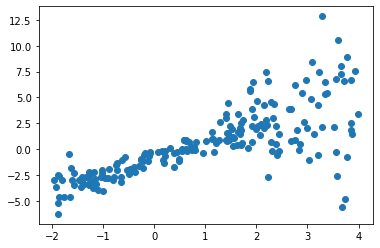

In [28]:
## create a random toy dataset for regression
 
np.random.seed(0)

def make_random_data():
    x = np.random.uniform(low=-2, high=4, size=200)
    y = []
    for t in x:
        r = np.random.normal(loc=0.0,
                             scale=(0.5 + t*t/3),
                             size=None)
        y.append(r)
    return  x, 1.726*x -0.84 + np.array(y)

x, y = make_random_data()

plt.plot(x, y, 'o')
plt.show()

Epoch    0: 12.2230
Epoch   50: 8.3876
Epoch  100: 6.5721
Epoch  150: 5.6844
Epoch  200: 5.2269
Epoch  250: 4.9725
Epoch  300: 4.8169
Epoch  350: 4.7119
Epoch  400: 4.6347
Epoch  450: 4.5742


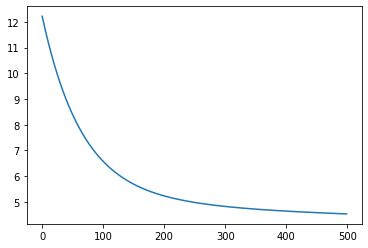

In [29]:
## train/test splits
x_train, y_train = x[:100], y[:100]
x_test, y_test = x[100:], y[100:]
 
n_epochs = 500
training_costs = []
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())

    ## train the model for n_epochs
    for e in range(n_epochs):
        c, _ = sess.run([cost, train_op],
                        feed_dict={tf_x: x_train,
                                   tf_y: y_train})
        training_costs.append(c)
        if not e % 50:
            print('Epoch %4d: %.4f' % (e, c))

plt.plot(training_costs)
plt.show()

### Define the model as a Python class

In [8]:
class TfLinreg(object):
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        # build the model
        with self.g.as_default():
            # set graph-level random seed
            tf.set_random_seed(random_seed)
            
            self.build()
            # create initializer
            self.init_op = tf.global_variables_initializer()
    
    def build(self):
        # define placeholders for inputs
        self.X = tf.placeholder(dtype=tf.float32,
                                shape=(None),
                                name='x_input')
        self.y = tf.placeholder(dtype=tf.float32,
                                shape=(None),
                                name='y_input')
        print(self.X)
        print(self.y)
        # define weight matrix and bias vector
        w = tf.Variable(tf.zeros(shape=(1)), name='weight')
        b = tf.Variable(tf.zeros(shape=(1)), name='bias')
        print(w)
        print(b)
        
        self.z_net = tf.squeeze(w * self.X + b, name='z_net')
        print(self.z_net)
        # compute squared errors
        sqr_errors = tf.square(self.y - self.z_net, name='sqr_errors')
        print(sqr_errors)
        # compute mean cost
        self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost')
        
        optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=self.learning_rate,
            name = 'GradientDescent'
        )
        
        self.optimizer = optimizer.minimize(self.mean_cost)
        

### Train the model

In [9]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                   2.0, 5.0, 6.3,
                   6.6, 7.4, 8.0, 9.0])
       
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Net input: Tensor("z_net:0", dtype=float32)
Squared errors: Tensor("sqr_errors:0", dtype=float32)


In [10]:
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    # initialize all variables: W and b
    sess.run(model.init_op)
    
    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost],
                           feed_dict={model.X: X_train,
                                      model.y: y_train})
        training_costs.append(cost)
    
    return training_costs

In [11]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)
print("Model fit")

Model fit


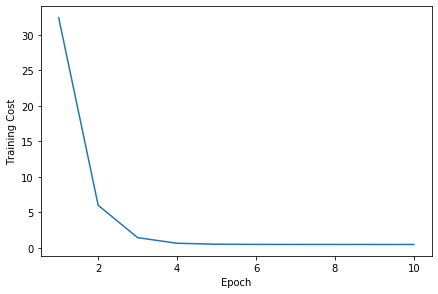

In [13]:
plt.plot(range(1,len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.show()

### Use the model to make predictions

In [14]:
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net, feed_dict={model.X: X_test})
    return y_pred

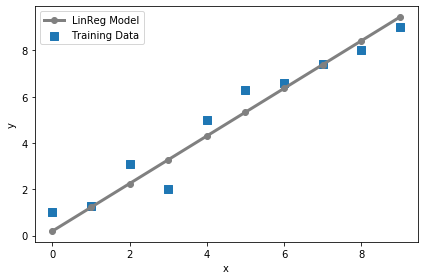

In [15]:
plt.scatter(X_train, y_train,
            marker='s', s=50,
            label='Training Data')
plt.plot(range(X_train.shape[0]),
         predict_linreg(sess, lrmodel, X_train),
         color='gray', marker='o',
         markersize=6, linewidth=3,
         label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()


## Computing a discrete convolution in a single dimension
A discrete convolution for two one-dimensional vectors $\boldsymbol{x}$ and $\boldsymbol{w}$ is denoted by $\boldsymbol{y} = \boldsymbol{x} * \boldsymbol{w}$, in which vector $\boldsymbol{x}$ is the input (sometimes called signal) and $\boldsymbol{w}$ is called the filter or kernel.

$ \large{ \boldsymbol{y} = \boldsymbol{x} * \boldsymbol{w} \to \boldsymbol{y} \left[ i \right] \sum \limits_{k = - \infty}^{+ \infty} \boldsymbol{x} \left[ i - k \right] \boldsymbol{w} \left[ k \right] } $

Let's assume that the original input $\boldsymbol{x}$ and filter $\boldsymbol{w}$ have $n$ and $m$ elements, respectively, where $m \leq n$. Therefore, the padded vector $\boldsymbol{x}^p$ has the size $n + 2p$. Then, the practical formula for computing a discrete convolution will change to the following:

$ \large{ \boldsymbol{y} = \boldsymbol{x} * \boldsymbol{w} \to \boldsymbol{y}\left[i\right] = \sum \limits_{k=0}^{k=m-1} \boldsymbol{x}^p \left[ i + m - k \right] \boldsymbol{w}[k] } $

Since in this summation $\boldsymbol{x}$ and $\boldsymbol{w}$ are indexed in the opposite direction, we can flip one of this vectors after they are padded and simply compute their dot product.

If we flip the filter $\boldsymbol{w}$ to get the rotated filter $\boldsymbol{w}^r$, the dot product $\boldsymbol{x} \left[i:i+m\right].\boldsymbol{w}^r$ is computed to get one element $\boldsymbol{y}\left[i\right]$, where $\boldsymbol{x}\left[i:i+m\right]$ is a patch of $\boldsymbol{x}$ with size $m$. 

The operation is repeated like a sliding window approach to get all the output elements. The shift, or stride $s$, of the rotated filter $\boldsymbol{w}^r$ is another hyperparameter of a convolution.

The output size of a convolution is determined by the total number of times that we shift the filter $\boldsymbol{w}$ along the input vector. If the input vector has the size $n$ and the filter is of the size $m$, then the output resulting from convolition $\boldsymbol{x}*\boldsymbol{w}$ with padding $p$ and stride $s$ can be determined as follows:

$ \large{ o = \lfloor \frac{n + 2p - m} {s} \rfloor } $

For example, for an input vector with size 10, with a convolution kernel of size 5, padding 2 and stride 1:

$ \large{ n=10, m=5, p=2, s=1 \to o = \lfloor \frac{10 + 2 \times 2 - 5} {1} \rfloor } + 1 = 10 $

In [15]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad,
                                   x_padded,
                                   zero_pad])
    res = []
    for i in range(0, int(len(x) / s), s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
    
    return np.array(res)

In [16]:
## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

In [17]:
print('Conv1d Implementation:', conv1d(x, w, p=2, s=1))

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]


In [18]:
print('Numpy Results:', 
np.convolve(x, w, mode='same'))

Numpy Results: [ 5 14 16 26 24 34 19 22]


## Computing a discrete convolution in two dimensions
The concepts of computing a discrete convolution in a single dimension are easily extensible to two dimensions. In case of a two-dimensional input, such as a matrix $\large{\boldsymbol{X}_{n_1 \times n_2}}$ and the filter matrix $\large{\boldsymbol{W}_{m_1 \times m_2}}$, where $m_1 \leq n_1$ and $m_2 \leq n_2$, then the matrix $\boldsymbol{Y} = \boldsymbol{X} * \boldsymbol{W}$ is the result of 2D convolution of $\boldsymbol{X}$ with $\boldsymbol{W}$. This is mathematically defined as follows:

$ \large{ \boldsymbol{Y} = \boldsymbol{X} * \boldsymbol{W} \to \boldsymbol{Y} \left[ i, j \right] = \sum \limits_{k_1= -\infty}^{+ \infty} } \sum \limits_{k_2 = - \infty }^{+ \infty} \boldsymbol{X} \left[ i - k_1, j - k_2 \right] \boldsymbol{W} \left[ k_1, k_2 \right] $

Notice that if you omit one of the dimensions, the remaining formula is exactly the same as the one we used previously to compute the convolution in 1D. In fact, all the previously mentioned techniques, such as zero-padding, rotating the filter matrix, and the use of strides, are also applicable to 2D convolutions, provided that they are extended to both the dimensions independently.

In [19]:
def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1, ::-1] # notice that rotation is NOT the same as the transpose matrix
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2 * p[0] # size of the input matrix with zero-padding
    n2 = X_orig.shape[1] + 2 * p[1] # size of the input matrix with zero-padding
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
             p[1]:p[1]+X_orig.shape[1]] = X_orig
    res = []
    for i in range(0, int((X_padded.shape[0] - \
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - \
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

In [20]:
X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

In [21]:
print('Conv2d Implementation:\n',
      conv2d(X, W, p=(1, 1), s=(1, 1)))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]


In [22]:
import scipy.signal

print('SciPy Results:\n', 
      scipy.signal.convolve2d(X, W, mode='same'))

SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## Deep convolutional neural network using TensorFlow